In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time 
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import xgboost as xgb
import math 
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from geopy.distance import great_circle

In [2]:
def drop_virgule(x):
    try:return x.split('.')[0]
    except:return x

def distance_to_mid_center(lat, lon):
    berlin_center = (52.5200, 13.4050)
    accommodation = (lat, lon)
    return great_circle(berlin_center, accommodation).km


def processing(df):
    df.drop(columns=columns_to_drop,inplace=True) #specified irrelevant columns 
    
    df.dropna(subset=['Price'], inplace=True)    #drop price missing (9rows)
    
    df['Listing ID']=df['Listing ID'].apply(drop_virgule)              # Drop the '.0' in IDs and Postal Code
    df['Host ID']=df['Host ID'].apply(drop_virgule)
    df['Postal Code']=df['Postal Code'].apply(drop_virgule)
    
    df['Host Since']=pd.to_datetime(df['Host Since'])                  # Convert values to datetime
    df['First Review']=pd.to_datetime(df['First Review'])
    df['Last Review']=pd.to_datetime(df['Last Review'])
    
    df['Accomodates'].replace('*', np.nan,inplace=True)                 # Put NaN in missing values where we have *
    df['Bathrooms'].replace('*', np.nan,inplace=True)
    df['Bedrooms'].replace('*', np.nan,inplace=True)
    df['Beds'].replace('*', np.nan,inplace=True)
    df['Guests Included'].replace('*', np.nan,inplace=True)
    df['Min Nights'].replace('*', np.nan,inplace=True)
    df['Postal Code'].replace('*', np.nan,inplace=True)
    df['neighbourhood'].replace('*', np.nan,inplace=True)
    df['Property Type'].replace('*', np.nan,inplace=True)
    df['Host Response Rate'].replace('*', np.nan,inplace=True)

    #from 98% to 0.98
    df['Host Response Rate'].replace('nan', np.nan,inplace=True)
    df['Host Response Rate']=df[~df['Host Response Rate'].isnull()]["Host Response Rate"].str.split('%').apply(lambda x:float(x[0])/100)

    df['Accomodates'] = df['Accomodates'].astype('float')              # Convert values to float
    df['Bathrooms'] = df['Bathrooms'].astype('float')
    df['Bedrooms'] = df['Bedrooms'].astype('float')
    df['Beds'] = df['Beds'].astype('float')
    df['Guests Included'] = df['Guests Included'].astype('float')
    df['Min Nights'] = df['Min Nights'].astype('float') 
    
    df.columns = df.columns.str.lower().str.replace(' ','_')           # Rename the columns with '_' instead of ' '

    #distance from center of berlin
    df['distance_to_midcenter'] = df.apply(lambda x: distance_to_mid_center(x.latitude, x.longitude), axis=1)
    return df

def processing_2(df):
    
    numerical_columns = df.select_dtypes(exclude=object).columns   # numeric columns names
    categorical_columns = df.select_dtypes(include=object).columns # categorical columns names
    
    df_cleaned_num = df[numerical_columns]    # dataframe with numeric columns only
    df_cleaned_cat = df[categorical_columns]  # dataframe with categorical columns only
    
    #standardisation for numeric columns
    scalerx = StandardScaler() 
    df_scaled=pd.DataFrame(scalerx.fit_transform(df_cleaned_num), columns = numerical_columns)
    
    #one encoder for categorical columns
    df_encoded=pd.DataFrame() 
    for cat in categorical_columns:
        df_temp = pd.get_dummies(df_cleaned_cat[cat], prefix=cat)
        df_encoded=pd.concat([df_temp, df_encoded], axis=1)
    
    #concatenation of numeric and categorical dataframes
    df_scaled.reset_index(drop=True, inplace=True)
    df_encoded.reset_index(drop=True, inplace=True)
    df_final=pd.concat([df_scaled, df_encoded], axis=1) 
    
    #KNN imputer (n=5 ????)
    imputer = KNNImputer(n_neighbors=5)
    df_final = pd.DataFrame(imputer.fit_transform(df_final),columns = df_final.columns)
    
    return df_final 


In [4]:
path='/Users/Pierr/OneDrive/Documents/CentraleSupelec/MLAirBnb/train_airbnb_berlin.csv'
my_sep,my_encoding=',','utf-8'
columns_to_drop=['Listing Name','Host Name','City','Country Code','Country']
types={'Listing ID':'str','Host ID':'str','Postal Code':'str'}
data=pd.read_csv(path,sep=my_sep,encoding=my_encoding,dtype=types)

#processing 1: drop the irrelevant columns / replace '*' values by nan / standardisation of columns name
df=processing(data)

df.drop(columns=['host_since','last_review','first_review','square_feet',
                 'business_travel_ready','host_id','listing_id','host_since',
                 'first_review','last_review','neighborhood_group'],inplace=True)

# droping outlighers for prices >300
df = df[~(df['price'] > 300)]

#droping rows where there is more than 3 nan 
#from dataviz we saw that it was the best option
df=df[df.isnull().sum(1)<4]

#processing 2: standardisation / one-hot-encoder / KNN imputer
df=processing_2(df)
print(df.shape)
df

(12622, 228)


,host_response_rate,latitude,longitude,accomodates,bathrooms,bedrooms,beds,guests_included,min_nights,reviews,...,neighbourhood_Wilhelmstadt,neighbourhood_Wilmersdorf,neighbourhood_Wittenau,neighbourhood_Zehlendorf,is_superhost_f,is_superhost_t,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour
0,0.394467,1.175537,0.172116,-0.471371,-0.314926,-0.238267,-0.561690,-0.472320,-0.238624,-0.421896,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.505893,1.776806,0.245246,-0.471371,-0.314926,1.404082,0.360710,0.913122,0.132964,-0.421896,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.281922,1.204307,0.298446,0.245177,-0.314926,-0.238267,0.360710,-0.472320,-0.312942,-0.515852,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.203140,-0.018597,0.752990,-0.471371,-0.314926,-0.238267,-0.561690,-0.472320,-0.238624,-0.468874,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.394467,-2.000847,-0.033061,0.245177,-0.314926,-0.238267,0.360710,0.913122,-0.312942,-0.327940,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12617,-0.393348,0.563600,-1.223574,-1.187919,-0.314926,-0.238267,-0.561690,-0.472320,-0.015672,-0.492363,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
12618,-0.730982,0.524485,-0.190756,-0.471371,-0.314926,-0.238267,-0.561690,-0.472320,-0.312942,-0.539341,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
12619,-3.375787,-0.646374,-0.269950,-0.471371,1.490561,-0.238267,-0.561690,-0.472320,0.058646,-0.304451,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
12620,-0.359584,-1.108641,0.790767,3.827915,3.296048,3.046432,3.127911,-0.472320,-0.312942,-0.468874,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [5]:
X=df.drop(columns=['price'])
y=df['price'].copy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import xgboost as xgb

regressor = xgb.XGBRegressor(
    n_estimators=150,
    reg_lambda=2,
    gamma=1,
    max_depth=3
)
regressor.fit(X_train, y_train)

In [ ]:
import math 
from sklearn import metrics

y_pred = regressor.predict(X_test)
print('rmse ',math.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('r2   ',metrics.r2_score(y_test, y_pred))

In [38]:
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test) 
print(y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
print ('mse = {}, rmse = {} \nmae = {} r2 = {}'.format(mse,math.sqrt(mse), mae, r2))

[-0.77313232  2.10848999 -1.15313721 ... -0.68606567 -0.38806152
  1.34841919]
mse = 0.5181007799784776, rmse = 0.719792178325437 
mae = 0.4840932886244716 r2 = 0.4921320845693653


In [ ]:
from lazypredict.Supervised import LazyRegressor
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

In [6]:
import pandas as pd
import numpy as np
import time
import plotly.express as px
import matplotlib.ticker as ticker
import seaborn as sns

import pickle
!pip install cchardet
#import cchardet
from bs4 import BeautifulSoup, SoupStrainer
#import requests
import re

from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

#import lightgbm as lgb
import sklearn.ensemble as sk_en
import sklearn.linear_model as sk_lm
import tensorflow as tf
from tensorflow import keras
import sklearn.metrics as sklm
from collections import defaultdict
import importlib
import sklearn
from sklearn import svm
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")


from collections import defaultdict
import importlib
def get_sklearn_algorithms (verbose = False):
    algos = defaultdict(list)
    if (verbose) : 
        print(dir(sklearn))
    for nom_module in dir(sklearn):
        if (verbose) : 
            print(nom_module)
        try:
            to_import = "sklearn.%s"%nom_module
            module = importlib.import_module(to_import)
            for nom_fonction in dir(module):
                fonction = getattr(module,nom_fonction)
                if (hasattr(fonction,"fit")):
                    if (verbose) : 
                        print(" nom algorithme =",nom_fonction)
                    algos [nom_module].append(fonction)
        except Exception as e:
            if (verbose) : 
                print(e)
        if (verbose) : 
            print("="*30)
    return algos
algos = get_sklearn_algorithms()
for key in algos.keys():
    print("\n===>",key)
    algos_ = []
    for algo in algos[key]:
        classe_algo = str(algo)
        nom_algo = classe_algo[str(classe_algo).rfind(".")+1:str(classe_algo).rfind("")]
        algos_.append(nom_algo)
    print(",".join(algos_)) 

algos['decomposition'] = []
algos['neighbors'] = []
algos['preprocessing'] = []
algos['model_selection'] = []
performances = {}
modeles_a_tester = []
classes_de_modeles_a_tester = algos.keys()
best_algorithm = 0
best_perf = 0

for classe_de_modeles in classes_de_modeles_a_tester :
    modeles_a_tester.extend(algos[classe_de_modeles])

for pointeur_vers_algo in modeles_a_tester :
    try:
        algorithme = pointeur_vers_algo()
        doc = algorithme.__doc__
        name = doc[:min(doc.find(":"),28)].strip()
        print(name)
        if ('regress' in name.lower()):
              print('Regression Model')
        else:
            algorithme.fit(X_train,y_train)
            predictions = algorithme.predict(X_test)
            rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions))
            print(rmse)
            performances[name] = [rmse]
  
    except Exception as e: 
        print(str(e)[:50])
    print("="*30)

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [11 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-310
      creating build\lib.win-amd64-cpython-310\cchardet
      copying src\cchardet\version.py -> build\lib.win-amd64-cpython-310\cchardet
      copying src\cchardet\__init__.py -> build\lib.win-amd64-cpython-310\cchardet
      running build_ext
      building 'cchardet._cchardet' extension
      error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for cchardet
  error: subprocess-exited-with-error
  
  × Running setup.py install for cchardet did not run successfully.
 

  Using cached cchardet-2.1.7.tar.gz (653 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for cchardet
Failed to build cchardet
  Running setup.py install for cchardet: started
  Running setup.py install for cchardet: finished with status 'error'

===> decomposition
DictionaryLearning'>,FactorAnalysis'>,FastICA'>,IncrementalPCA'>,KernelPCA'>,LatentDirichletAllocation'>,MiniBatchDictionaryLearning'>,MiniBatchNMF'>,MiniBatchSparsePCA'>,NMF'>,PCA'>,SparseCoder'>,SparsePCA'>,TruncatedSVD'>

===> dummy
DummyClassifier'>,DummyRegressor'>

===> ensemble
AdaBoostClassifier'>,AdaBoostRegressor'>,BaggingClassifier'>,BaggingRegressor'>,ExtraTreesClassifier'>,ExtraTreesRegressor'>,GradientBoostingClassifier'>,GradientBoostingRegressor'>,HistGradientBoostingClassifier'>,HistGradientBoostingRegressor'>,IsolationForest'>,RandomForestClassifier'>,RandomForestRegressor'>,RandomTreesEmbedding'>,StackingClassifier'>,Stacki

In [7]:
performances

{'DummyClassifier makes predic': [1.035812348398973],
 'Gradient Boosting for regres': [0.6936770742981008],
 'Histogram-based Gradient Boo': [0.6999847038220725],
 'Isolation Forest Algori': [1.4183989960027634],
 'Elastic Net model with itera': [0.7057831406990768],
 'L2-regularized linear regres': [0.7239782278856679],
 'Cross-validated Least Angle': [0.7072620036129038],
 'Linear Model trained with L1': [1.00943798096198],
 'Lasso linear model with iter': [0.7056008987837789],
 'Lasso model fit with Least A': [1.00943798096198],
 'Cross-validated Lasso, using': [0.7075422386930704],
 'Lasso model fit with Lars us': [0.7063953032301473],
 'Ordinary least squares': [0.7075718340881828],
 'Orthogonal Matching Pursuit': [0.7149492318424271],
 'Cross-validated Orthogonal M': [0.7149492318424271],
 'RANSAC (RANdom SAmple Consen': [257588112.64809173],
 'Linear least squares with l2': [0.705570934884085],
 'Solves linear One-Class SVM': [1.425279448780084],
 'Linear model fitted by minim'

In [43]:
from sklearn.decomposition import PCA
pca = PCA(n_components=40)
pca.fit(X_train)
print(pca.explained_variance_ratio_)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

[0.16634085 0.1393577  0.06957061 0.05252731 0.05073963 0.04785024
 0.04003343 0.03915555 0.0352909  0.03258964 0.02879571 0.02615865
 0.02334862 0.02250996 0.02039517 0.01908137 0.01848189 0.01765291
 0.01553471 0.01299079 0.0108372  0.00919916 0.00771645 0.00718196
 0.00652402 0.00560637 0.00553205 0.00488428 0.00406985 0.00286911
 0.00266903 0.00219014 0.00177292 0.00173387 0.00154383 0.00147776
 0.00129095 0.00120437 0.00114172 0.00113852]


In [44]:
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error

# Some libraries for PCA visualization
import seaborn as sns 
#Make Plotly figure
#import chart_studio.plotly as py
# Be aware, plotly may be installed using pip on your shell:
#conda install -c plotly chart-studio
import plotly.graph_objs as go

pca = PCA()
X_reduced = pca.fit_transform(scale(X))
X_reduced.shape

(12622, 227)

[1.000041839162023, 0.927363977108221, 0.6129426766336081, 0.6068259049818508, 0.5635608572477332, 0.5427202885915317, 0.5360706457650719, 0.5335230670575453, 0.5320627096234735, 0.5316152417208734, 0.5316793760837941, 0.5317631546412571, 0.5316984319633024, 0.5316142210930127, 0.5305357540092678, 0.5302402977729053, 0.5302876638147743, 0.5300761968343074, 0.5302030260334886, 0.5302539205480845, 0.5295148521241719, 0.5293591458051251, 0.5294195578893819, 0.5295783626669535, 0.5295880316111539, 0.5295540776605557, 0.5296090520279384, 0.5296963279971552, 0.5297900847712081, 0.529095437195132, 0.5280050132632896, 0.5280741107768718, 0.5280948455256012, 0.5280839388275165, 0.5281065254248729, 0.5279227352022201, 0.5279641425356609, 0.5279816783978128, 0.5273679158310762, 0.5272737510292143]


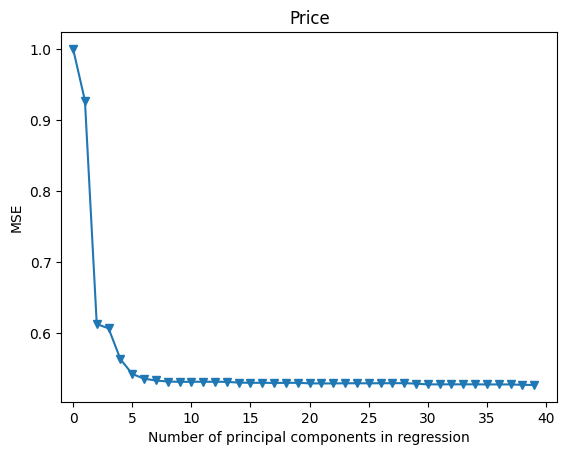

In [46]:
# 10-fold CV, with shuffle
n = len(X_reduced)

kf_10 = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principal components, adding one component at the time.
for i in np.arange(1, 40):
    score = -1*model_selection.cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot results    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Price')
plt.xlim(xmin=-1);

print(mse)

In [47]:
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

[  1.78   3.46   4.92   6.21   7.4    8.52   9.5   10.45  11.39  12.32
  13.24  14.14  15.03  15.91  16.79  17.66  18.53  19.39  20.24  21.09
  21.93  22.76  23.59  24.41  25.23  26.05  26.87  27.68  28.49  29.29
  30.08  30.87  31.65  32.43  33.21  33.98  34.75  35.51  36.26  37.
  37.73  38.45  39.17  39.87  40.56  41.25  41.92  42.59  43.25  43.9
  44.54  45.17  45.77  46.35  46.91  47.44  47.97  48.49  49.    49.5
  49.99  50.48  50.97  51.46  51.94  52.42  52.9   53.37  53.84  54.31
  54.78  55.24  55.7   56.16  56.62  57.08  57.54  57.99  58.44  58.89
  59.34  59.79  60.24  60.69  61.14  61.59  62.04  62.49  62.94  63.39
  63.84  64.29  64.74  65.19  65.64  66.09  66.54  66.99  67.44  67.89
  68.34  68.78  69.22  69.66  70.1   70.54  70.98  71.42  71.86  72.3
  72.74  73.18  73.62  74.06  74.5   74.94  75.38  75.82  76.26  76.7
  77.14  77.58  78.02  78.46  78.9   79.34  79.78  80.22  80.66  81.1
  81.54  81.98  82.42  82.86  83.3   83.74  84.18  84.61  85.04  85.46
  85.88  86.2

[0.9769126152452667, 0.8556046212424834, 0.6053649018865283, 0.5970205815609244, 0.5519110203835569, 0.5429782945328435, 0.5382431324212475, 0.5337482188343732, 0.532826756828461, 0.5327207608004856, 0.5329526801519252, 0.5329274747279845, 0.5332586674518727, 0.5334472504208322]


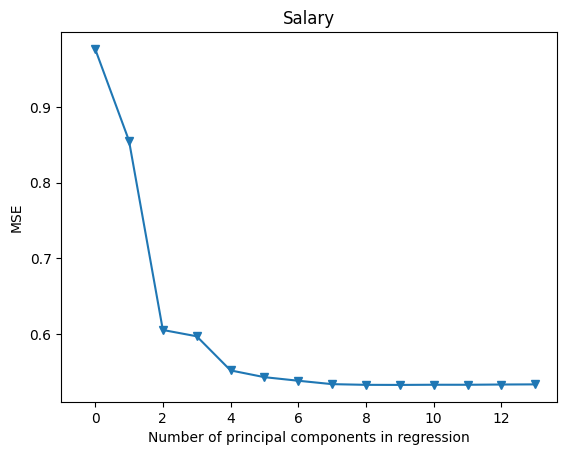

In [48]:
pca2 = PCA()

# Split into training and test sets
X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, test_size=0.5, random_state=1)

# Scale the data and fit the PCA 
# .fit_transform(X) fit the model with X and apply the dimensionality reduction on X
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)


# 10-fold CV, with shuffle
kf_10 = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)

mse = []

# Compute MSE with only the intercept (no principal components in regression)
#and 10-fold CV is only applied on the train set
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)
#print(mse)


# Compute MSE using CV for the 19 principal components, adding one component at the time
#10-fold CV is only applied on the train set
for i in np.arange(1, 14):
    score = -1*model_selection.cross_val_score(regr, X_reduced_train[:,:i], y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

print(mse)

In [57]:
X_reduced_test = pca2.fit_transform(scale(X_test))[:,:15]

#print(X_reduced_test.shape)
#pd.DataFrame(X_reduced_test).info()

# If you want to compare before and after to apply the PCA:
#print(pd.DataFrame(X_reduced_test).describe())
#print(pd.DataFrame(scale(X_test)).describe())

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:15], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
print('The final test MSE is: ',mean_squared_error(y_test, pred))
print('The final test RMSE is: ', math.sqrt(mean_squared_error(y_test, pred)))

The final test MSE is:  0.7420417780839431
The final test RMSE is:  0.8614184686225058
